<a href="https://colab.research.google.com/github/theevildoof/3D-Unity-game-using-MPU6050-and-TinyML/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.0.0

Selecting previously unselected package xxd.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86.3 MB 43 kB/s 
     |████████████████████████████████| 50 kB 7.7 MB/s 
     |████████████████████████████████| 449 kB 54.0 MB/s 
     |████████████████████████████████| 3.8 MB 19.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=e851a44534c0c128b8b6b4a55d917c2585f57fcf85826ad7b8b8b8709a818cb8
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef

We are building an One-Class Classification problem

Resources: 

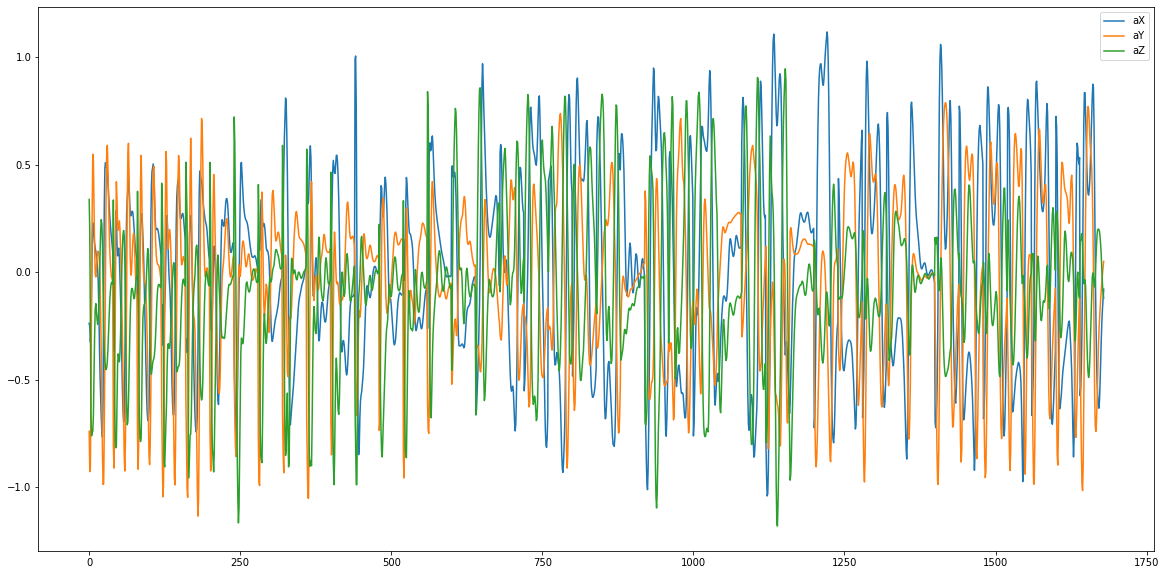

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "noshoot42.csv"

plt.rcParams["figure.figsize"] = (20,10)
headers = ['aX', 'aY', 'aZ']
df = pd.read_csv(filename, names=headers)
df['aY'] = df['aY'] /16384
df['aX'] = df['aX'] /16384
df['aZ'] = df['aZ'] /16384
#df.head(80).plot()
df.plot()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = ["noshoot42","shoot42"]

SAMPLES_PER_GESTURE = 40

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv( gesture + ".csv",names = headers)
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index]) / 16384,
          (df['aY'][index]) / 16384,
          (df['aZ'][index]) / 16384 
      ]

    inputs.append(tensor)
    outputs.append(output)
  #print(len(tensor))
# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.8.2

Processing index 0 for gesture 'noshoot42'.
	There are 42 recordings of the noshoot42 gesture.
Processing index 1 for gesture 'shoot42'.
	There are 42 recordings of the shoot42 gesture.
Data set parsing and preparation complete.


In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [ ]:
# build the model and train it
from tensorflow.keras import regularizers
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(10, activation='relu',kernel_regularizer= regularizers.L1(l1=1e-4)))
#model.add(tf.keras.layers.Dropout(rate=0.2, noise_shape = (1, 60), seed = 1))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation = 'softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=300, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/300
50/50 [==============================] - 2s 18ms/step - loss: 0.2366 - mae: 0.4831 - val_loss: 0.2118 - val_mae: 0.4556
Epoch 2/300
50/50 [==============================] - 0s 5ms/step - loss: 0.1945 - mae: 0.4361 - val_loss: 0.1842 - val_mae: 0.4211
Epoch 3/300
50/50 [==============================] - 0s 7ms/step - loss: 0.1512 - mae: 0.3798 - val_loss: 0.1434 - val_mae: 0.3653
Epoch 4/300
50/50 [==============================] - 0s 8ms/step - loss: 0.1068 - mae: 0.3123 - val_loss: 0.1101 - val_mae: 0.3095
Epoch 5/300
50/50 [==============================] - 0s 8ms/step - loss: 0.0720 - mae: 0.2479 - val_loss: 0.0883 - val_mae: 0.2603
Epoch 6/300
50/50 [==============================] - 0s 5ms/step - loss: 0.0504 - mae: 0.1964 - val_loss: 0.0697 - val_mae: 0.2204
Epoch 7/300
50/50 [==============================] - 0s 8ms/step - loss: 0.0336 - mae: 0.1539 - val_loss: 0.0601 - val_mae: 0.1874
Epoch 8/300
50/50 [==============================] - 0s 7ms/step - loss: 0.0240 - 

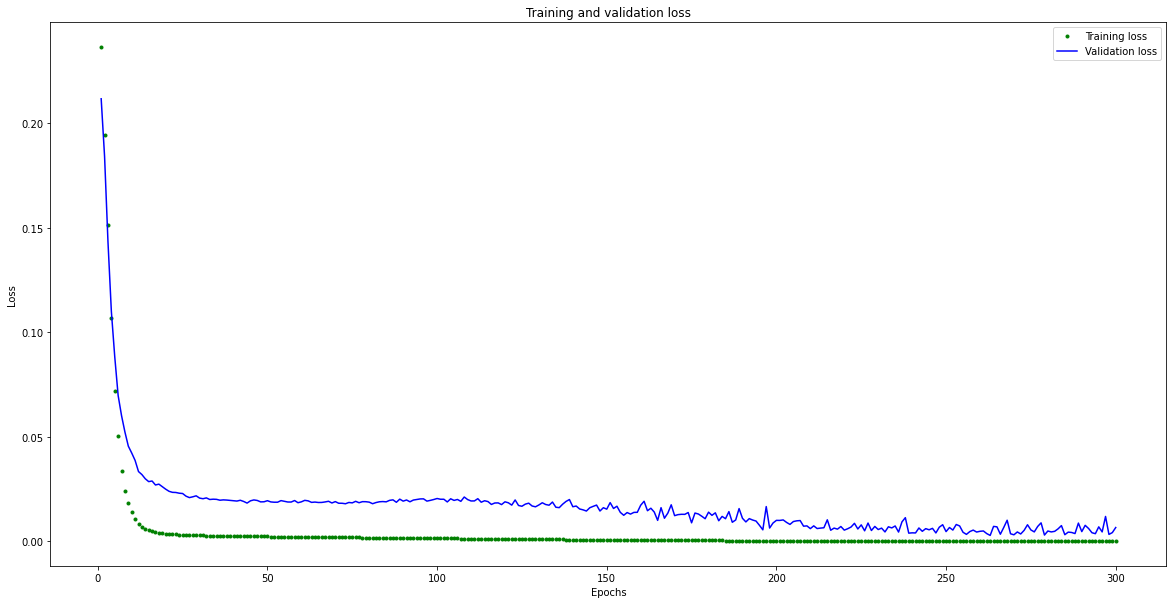

[20.0, 10.0]


In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

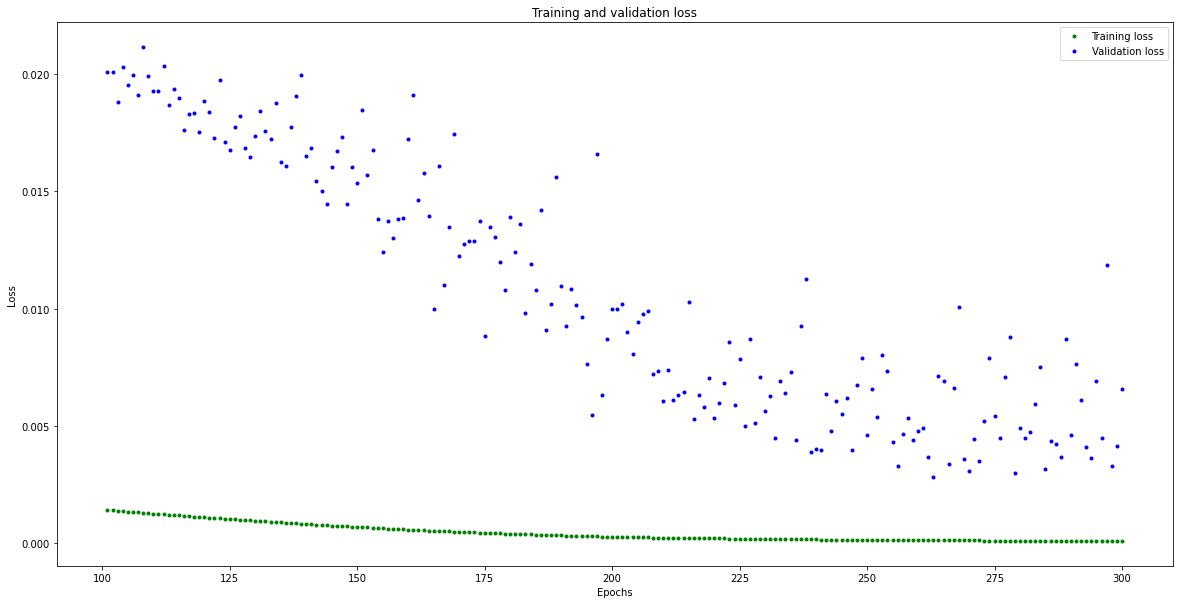

In [ ]:
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

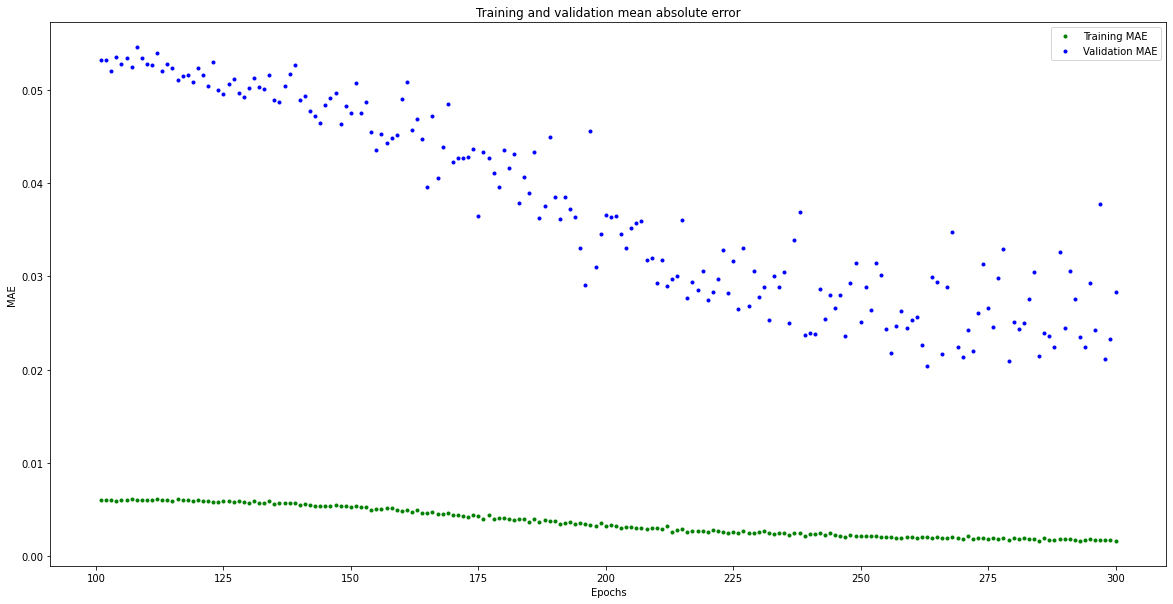

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

predictions =
 [[0.001 0.999]
 [0.012 0.988]
 [0.952 0.048]
 [0.989 0.011]
 [0.999 0.001]
 [1.    0.   ]
 [0.004 0.996]
 [0.001 0.999]
 [0.873 0.127]
 [0.783 0.217]
 [0.003 0.997]
 [0.995 0.005]
 [0.996 0.004]
 [0.998 0.002]
 [0.001 0.999]
 [0.    1.   ]]
actual =
 [[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()


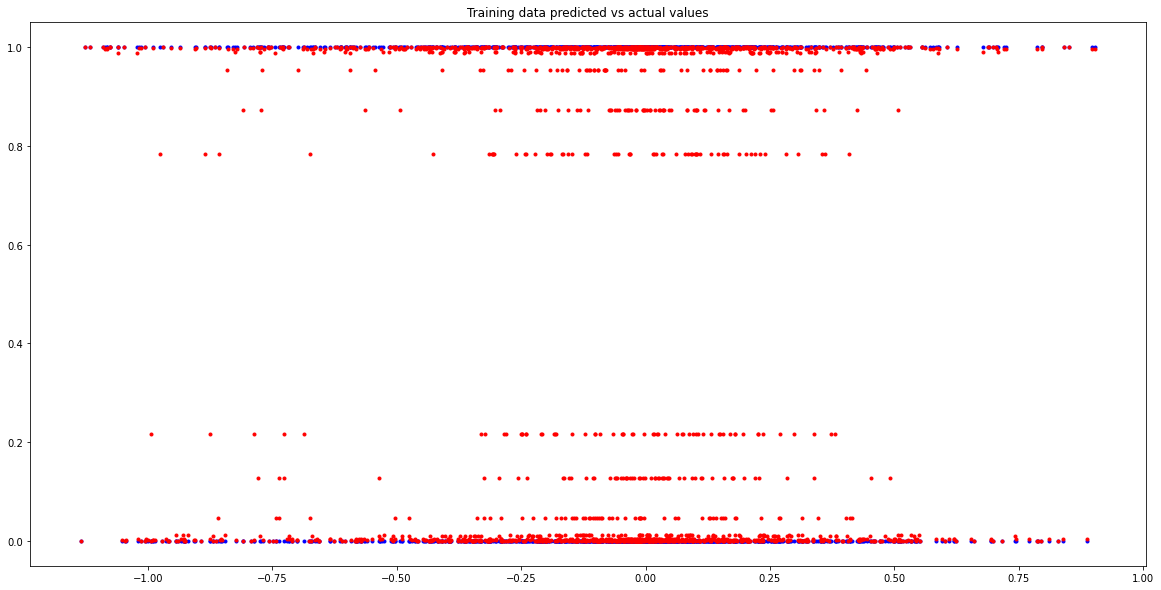

In [ ]:
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()


In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
!apt-get -qq install xxd
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Selecting previously unselected package xxd.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
INFO:tensorflow:Assets written to: /tmp/tmpgufo04fr/assets


INFO:tensorflow:Assets written to: /tmp/tmpgufo04fr/assets


Model is 7192 bytes


In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 44,386 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
